# Initial experiments for the flight path optimization

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")

from FOM_advectiondiffusion import FOM_advectiondiffusion
from FOM_advectiondiffusion_steadystate import FOM_advectiondiffusion_steadystate
from Drone import Drone
from Parameter import Parameter
from Brain import Brain
from NoiseModel import NoiseModel

import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

In [2]:
tStart_notebook = time.time()

## global user settings

In [3]:
meshDim = 50 
# meshDim=50 is probably too coarse but for writing the code it should suffice, I'm impatient

## model problem

In [4]:
fom = FOM_advectiondiffusion_steadystate(meshDim=meshDim)
fom_transient = FOM_advectiondiffusion(meshDim=meshDim)

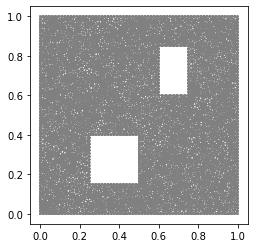

In [5]:
# how the mesh looks like
dl.plot(fom.mesh)

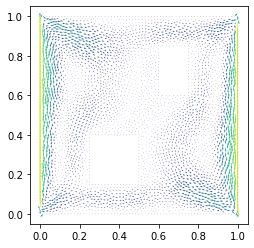

In [6]:
# how the velocity field looks like
dl.plot(fom.velocity)

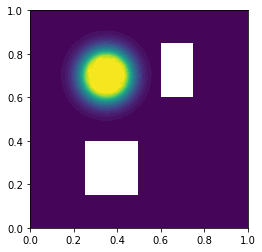

In [7]:
# initial condition
dl.plot(fom.m_true, mesh=fom.mesh)

In [8]:
# model solve
sol_transient, grid_t = fom.implicit_Euler(m_init=fom.m_true, dt=0.1, final_time=10)

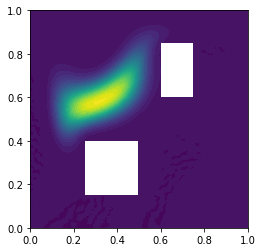

In [9]:
t = 0.8
k = np.argmin(np.abs(grid_t - t))
dl.plot(sol_transient[k], mesh=fom.mesh)

## Steady state

In [10]:
sol_steadystate = fom.solve_steady()

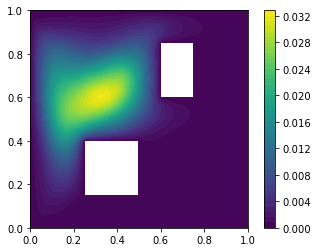

In [11]:
fom.plot(sol_steadystate)

## drone flies in a circle

In [12]:
# set default flying parameters
flying_parameters = {
                "radius" : 0.25,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.3
            }

drone = Drone(fom, grid_t=grid_t, flying_parameters=flying_parameters)

In [13]:
# for playing with different flight path, you can specify them anew when asking for the trajectory
flying_parameters_temp = flying_parameters

pos, __ = drone.get_trajectory(grid_t=grid_t, flying_parameters=flying_parameters_temp)

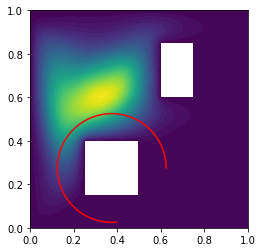

In [14]:
dl.plot(sol_steadystate, mesh=fom.mesh)
plt.plot(pos[:, 0], pos[:, 1], color="r")

## Taking measurements

### "convolution" measurements: truncated Gaussians

The drone flies over the point $y$ but then takes a measurement at a random location $x$ with $\|x-y\| \le \sigma$, i.e. a close point but not exactly $y$. The distribution for which $x$ is chosen is described by a truncated Gaussian. We can model this measurement statistically as the expectation of the state under this distribution.

\begin{align}
\Phi(x, y) = \left\{
\begin{array}{ll}
0 & \text{if } \|x-y\| \le 2\sigma \\
C\exp(-\frac{1}{2\sigma^2} \|x-y\|^2) & \text{otherwise}
\end{array}
\right.
\end{align}
where $C$ is chosen such that $\int_{\Omega} Phi(x, y) dx = 1$ for all $y$. We need the re-scaling such that $\Phi(\cdot, y)$ is indeed a probability densition function.

We define the measurement centered around a point $y \in \Omega$ of a state $u \in H^1(\Omega)$ as 
$$\ell_y(u) := \int_{\Omega} u(x) \Phi(x, y) dx 
= \int_{\|x-y\| \le 2\sigma} u(x) \Phi(x, y) dx 
= \mathbb{E}_{\pi_y}[u]
\in \mathbb{R}$$ 
where $\pi_y$ is the probability measure for the probability density function $\Phi(\cdot, y)$.



 measurement steadystate:  0.01620622613457551
 point evaluation:         0.018351257995877633
 compute time:             0.006062746047973633  s 

 measurement transient:    0.1323646311624418
 point evaluation:         0.1438173240671247
 compute time:             0.003773927688598633  s 



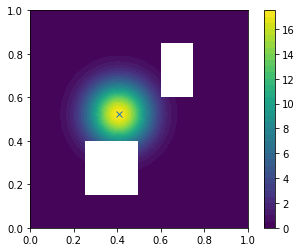

In [15]:
t = 1.2  # at which time should we take the measurement?
k = np.argmin(np.abs(grid_t - t))  # closest time step
pos_x, pos_y = pos[k, :]  # center point around which to take the measurement
sigma_gaussian = 0.1 #0.025  # standard deviation of gaussian functional
# measurement area will be cut off after 2*sigma_weight

# (unscaled) density function for normal distribution
weight = 'exp(-0.5 * ((x[0]-{})*((x[0]-{})) + (x[1]-{})*(x[1]-{})) / {})'.format(pos_x, pos_x, pos_y, pos_y, sigma_gaussian**2)

# cut off after twice the standard deviation (truncated normal)
weight_fct = dl.Expression('max({}, {})'.format(-np.exp(-1), weight), degree=1)  # ideally should use higher degree too

# re-weight such that the integral is = 1
val_integral = dl.assemble(weight_fct*dl.Measure('dx', fom.mesh))
weight_fct = weight_fct/val_integral

fom.plot(weight_fct)
plt.plot([pos_x],[pos_y], marker = 'x') # how the weight function looks like

tStart = time.time()
val_steadystate = dl.assemble(dl.inner(weight_fct, sol_steadystate) * dl.dx)
t_eval_steadystate = time.time()-tStart

tStart = time.time()
val_transient = dl.assemble(dl.inner(weight_fct, sol_transient[k]) * dl.dx)
t_eval_transient = time.time()-tStart

print("\n measurement steadystate: ", val_steadystate)
print(" point evaluation:        ", sol_steadystate([pos_x, pos_y]))
print(" compute time:            ", t_eval_steadystate, " s \n")


print(" measurement transient:   ", val_transient)
print(" point evaluation:        ", sol_transient[k]([pos_x, pos_y]))
print(" compute time:            ", t_eval_transient, " s \n")

**Note:** Note that we the standard deviation should be smaller here, but at some point the grid size isn't fine enough anymore to accomodate it, so for that reason I'll put `sigma_weight = 0.1` for now such that the measurement area around the drone is a circle with radius 0.2 (twice the standard deviation). The smaller we choose $\sigma$, the closer the measurement should be to the point evaluation.

**Note:** the compute time for the steady-state and the transient case should be comparable here. Sometimes I've seen though that the steady-state case takes a lot longer (almost 1 second), specifically when I change something like the position. So probably there's some caching going here. Unfortunately for the flying drone the measurement position is going to be different every time step, so we'll need to calculate with the worse compute time unfortuantely :(

Hopefully we can speed up some of these computations, I'm just going for the obvious steps right now, I'm not optimizing the code.

**Note:** Thinking back to my conversation with Don Blankenship about how they measure in Antarctica, I think this model makes sense: He mentioned that for any measurement there exists a point on the ground where this measurement is correct (modulo noise) but that the position of this point is only known within an interval of 8m on the right-left axis of the plane. He also said something about how far the divice measures towards forwards and backwards, but I don't have that information at hand. In any case, using an iid Gaussian is probably not ideal, but a truncated Gaussian makes sense I think.

### "convolution" measurements: uniform

Another possibility for modelling the measurements is to choose a weighted characteristic function $\Phi(x,y) = \|\Omega_y\|^{-1} \mathbb{1}_{\Omega_y}(x)$ for a measureable domain $\Omega_y \subset \Omega$, $y \in \Omega_y$. In this case a measurement 
$$\ell_y(u) := \int_{\Omega} u(x) \Phi(x,y) dx = \frac{1}{\|\Omega_y\|} \int_{\Omega_y} u(x) dx$$ 
is the mean value of a state $u$ over the subdomain $\Omega$. In the code below I've chosen $\Omega_y$ as a circle around the point $y$. Well, at least it's a circle when it completely fits into the doamin.


 measurement steadystate:  0.017904956399253324
 point evaluation:         0.018351257995877633
 compute time:             0.047512054443359375  s 

 measurement transient:    0.15982405606337477
 point evaluation:         0.1438173240671247
 compute time:             0.04719281196594238  s 



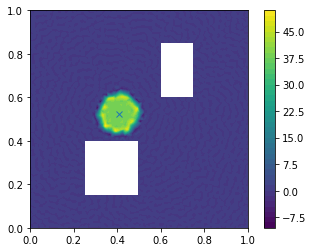

In [16]:
# for comparison, let's use the same setting as before. 
# the cutoff radius before was 2*sigma_weight, so we could keep the reach of the measurement the same with
# radius_uniform = 2 * sigma_gaussian
# but for sigma_gaussian = 0.1 that seems ridiculously large
radius_uniform = sigma_gaussian

## If you want to try out changes faster, comment this code in:
# t = 1.2  # at which time should we take the measurement?
# k = np.argmin(np.abs(grid_t - t))  # closest time step
# pos_x, pos_y = pos[k, :]  # center point around which to take the measurement
# radius_uniform = 0.05 # radius around the center


class Omega_circle(dl.SubDomain):
    
    def __init__(self, pos, radius):
        super().__init__()
        self.center = pos
        self.radius = radius
    
    def inside(self, x, on_boundary):
        if la.norm(x - self.center) <= self.radius:
            return True
        return False
        
subdomain = Omega_circle(pos = np.array([pos_x, pos_y]), radius = radius_uniform)
material = dl.MeshFunction("size_t", fom.mesh, fom.mesh.topology().dim(), 0)
subdomain.mark(material, 1)

weight_fct = Parameter(material, np.array([0, 1]), degree = 0)

# re-weight such that the integral is = 1
val_integral = dl.assemble(weight_fct*dl.Measure('dx', fom.mesh))
weight_fct = weight_fct/val_integral
# we would just divide by (np.pi*radius_uniform**2) here, but if the mesh is not fine enough this will cause issues
# (we won't converge towards point evaluation even though that's our theoretical limit since our FE solution is continuous)

# how the weight function looks like
fom.plot(weight_fct)
plt.plot([pos_x],[pos_y], marker = 'x') 

tStart = time.time()
val_steadystate = dl.assemble(dl.inner(weight_fct, sol_steadystate) * dl.dx)
t_eval_steadystate = time.time()-tStart

tStart = time.time()
val_transient = dl.assemble(dl.inner(weight_fct, sol_transient[k]) * dl.dx)
t_eval_transient = time.time()-tStart

print("\n measurement steadystate: ", val_steadystate)
print(" point evaluation:        ", sol_steadystate([pos_x, pos_y]))
print(" compute time:            ", t_eval_steadystate, " s \n")


print(" measurement transient:   ", val_transient)
print(" point evaluation:        ", sol_transient[k]([pos_x, pos_y]))
print(" compute time:            ", t_eval_transient, " s \n")


### comparison

Computing the integrals can sometimes take a bit, so I'm introducing the slicer variable to only measure every so often, i.e. every `slicer`-th time step. This is only because I'm impatient when I run the notebook from the start, outside code development we will measure at every time step.

In [17]:
slicer = 40

tStart = time.time()

d_steadystate_gaussian = drone.measure(pos[::slicer, :], sol_steadystate, mode="gaussian")
d_steadystate_pointwise = drone.measure(pos, sol_steadystate, mode="point-eval")
d_steadystate_uniform = drone.measure(pos[::slicer, :], sol_steadystate, mode="uniform")

print("Runtime for half this block: {} min".format((time.time()-tStart)/60))

d_transient_gaussian = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="gaussian")
d_transient_pointwise = drone.measure(pos, sol_transient, mode="point-eval")
d_transient_uniform = drone.measure(pos[::slicer, :], sol_transient[::slicer], mode="uniform")

print("Runtime for this block: {} min".format((time.time()-tStart)/60))

Runtime for half this block: 0.004980397224426269 min
Runtime for this block: 0.009838982423146566 min


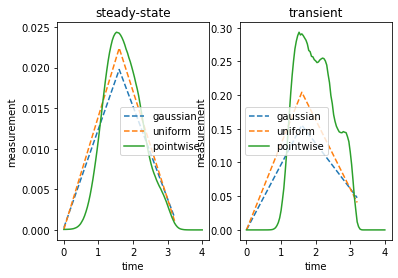

In [18]:
fig, axs = plt.subplots(1,2)
axs[0].plot(grid_t[::slicer], d_steadystate_gaussian, label="gaussian", linestyle = "--")
axs[0].plot(grid_t[::slicer], d_steadystate_uniform, label="uniform", linestyle = "--")
axs[0].plot(grid_t, d_steadystate_pointwise, label="pointwise")

axs[0].set_xlabel("time")
axs[0].set_ylabel("measurement")
axs[0].set_title("steady-state")
axs[0].legend()

axs[1].plot(grid_t[::slicer], d_transient_gaussian, label="gaussian", linestyle = "--")
axs[1].plot(grid_t[::slicer], d_transient_uniform, label="uniform", linestyle = "--")
axs[1].plot(grid_t, d_transient_pointwise, label="pointwise")

axs[1].set_xlabel("time")
axs[1].set_ylabel("measurement")
axs[1].set_title("transient")
axs[1].legend()

**note:** The gaussian measurements are further away from the pointwise measurements here because the measurement radius `2*drone.sigma_gaussian` is larger than `drone.radius_uniform`.

## Parameter-to-observable map

For the drone class I think it should mimick what the drone does in practice: flying and measureing. It doesn't necessarily evaluate probabilities itself or choose the parameters of its flight path. For these tasks I'm introducing a separate class `Brain`. If the drone eventually flies and measures autonomously think of `Brain` as the brain of the drone, if not, then it's the brain of the decisionmaker. 

In [19]:
brain = Brain(fom=fom, drone=drone)

In [20]:
d_test = brain.apply_para2obs(para=[1], mode="point-eval")
print("Sanity check: ", np.isclose(d_test,  d_steadystate_pointwise).all())

Sanity check:  True


**Note:** One reason for why the sanity check might fail is that the drone flight parameters, e.g., speed, might have changed from the defaults in the code above.

## Noise model


Mass matrix entries:
$$\int_0^{dt} \frac{s^2}{dt^2} ds = \frac13 dt$$

$$\int_0^{dt} \frac{s(dt-s)}{dt^2} ds =\frac{1}{dt^2}\int_0^{dt} dt*s - s^2 ds = \frac12 dt - \frac13 dt = \frac16 dt$$

In [60]:
noise_model = NoiseModel(grid_t=grid_t, c_scaling=1e+2, c_diffusion = 1e-1)

Text(0.5, 0, 'time')

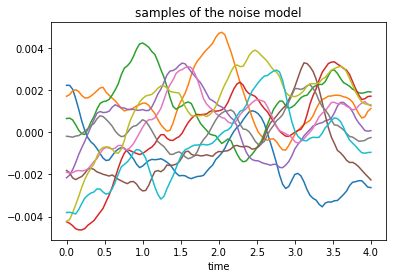

In [61]:
test = noise_model.sample(n_samples = 10)

fig, ax = plt.subplots(1,1)
for i in range(10):
    ax.plot(grid_t, test[:, i])
    
ax.set_title("samples of the noise model")
ax.set_xlabel("time")

In [55]:
# todo: double-check that this is indeed how samples are drawn

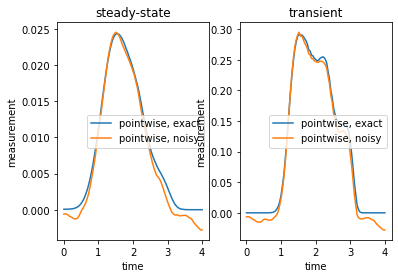

In [65]:
noise = noise_model.sample()

fig, axs = plt.subplots(1,2)
axs[0].plot(grid_t, d_steadystate_pointwise, label="pointwise, exact")
axs[0].plot(grid_t, d_steadystate_pointwise + noise, label="pointwise, noisy")

axs[0].set_xlabel("time")
axs[0].set_ylabel("measurement")
axs[0].set_title("steady-state")
axs[0].legend()

axs[1].plot(grid_t, d_transient_pointwise, label="pointwise, exact")
axs[1].plot(grid_t, d_transient_pointwise + 10*noise, label="pointwise, noisy")

axs[1].set_xlabel("time")
axs[1].set_ylabel("measurement")
axs[1].set_title("transient")
axs[1].legend()

**Note:** the measurements for the transient case are much larger, so we'll need a different noise model for that case (probably). Here, for better visibility of the noise, I've multiplied it with 10.

In [27]:
# welcome back!
# These are your next steps:
# noise covariance matrix
# compute posterior covariance matrix
# compute posterior mean
# evaluate OED utility functions

## The End.

In [28]:
t_notebook = time.time() - tStart_notebook
print("Runtime of this notebook: {} min".format(t_notebook / 60))

Runtime of this notebook: 0.1663317839304606 min
